#### download

In [1]:
import os

try:
    os.mkdir("images")
    os.mkdir("images/dogs")
    os.mkdir("images/cats")
except:
    pass

In [2]:
!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs

--2021-02-05 17:33:55--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.194.166, 151.101.66.166, 151.101.130.166, ...
접속 i.kinja-img.com (i.kinja-img.com)|151.101.194.166|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.1’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.02s   

2021-02-05 17:33:55 (1.23 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.1’ saved [32099/32099]

--2021-02-05 17:33:55--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
접속 www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 130940 (128K) [image/jpeg]
Saving to: ‘images/dogs/50_a

In [3]:
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

--2021-02-05 17:33:58--  https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg
Resolving www.catster.com (www.catster.com)... 192.124.249.102
접속 www.catster.com (www.catster.com)|192.124.249.102|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 165145 (161K) [image/jpeg]
Saving to: ‘images/cats/A-gray-cat-crying-looking-upset.jpg.1’

A-gray-cat-crying-l 100%[===================>] 161.27K   736KB/s    in 0.2s    

2021-02-05 17:33:58 (736 KB/s) - ‘images/cats/A-gray-cat-crying-looking-upset.jpg.1’ saved [165145/165145]

--2021-02-05 17:33:58--  https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700
Resolving www.scarymommy.com (www.scarymommy.com)... 141.193.213.21, 141.193.213.20
접속 www.scarymommy.com (www.scarymommy.com)|141.193.213.21|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 1892233 (1.8M) [image/jpeg]
Saving to: ‘images/cats/c1.jpg?w=700.1’

c1.jpg?w=700.1      100%[===================>]   1.80

#### module

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### hyper-parameters

In [6]:
batch_size = 1
learning_rate = 0.0002
num_epoch = 100

#### dataset

In [7]:
root_dir = "./images"

In [8]:
img_data = dset.ImageFolder(root_dir, transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                            ]))

In [9]:
train_loader = data.DataLoader(img_data, batch_size=batch_size, shuffle=True, num_workers=2)

#### model

In [10]:
# 1*1 합성곱
def conv_block_1(in_dim, out_dim, act_fn, stride=1):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=stride),
            act_fn,
            )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            act_fn,
            )
    return model

In [11]:
class BottleNeck(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, act_fn, down=False):
        super(BottleNeck, self).__init__()
        self.down = down
        
        if self.down:
            self.layer = nn.Sequential(
                            conv_block_1(in_dim, mid_dim, act_fn, 2),
                            conv_block_3(mid_dim, mid_dim, act_fn),
                            conv_block_1(mid_dim, out_dim, act_fn),
                            )
            self.downsample = nn.Conv2d(in_dim, out_dim, 1, 2)
        
        else:
            self.layer = nn.Sequential(
                            conv_block_1(in_dim, mid_dim, act_fn),
                            conv_block_3(mid_dim, mid_dim, act_fn),
                            conv_block_1(mid_dim, out_dim, act_fn),
                            )
            
        self.dim_equalizer = nn.Conv2d(in_dim, out_dim, kernel_size=1)
        
    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        
        else:
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, base_dim, 7, 2, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(3, 2, 1),
                        )
        self.layer2 = nn.Sequential(
                        BottleNeck(base_dim, base_dim, 4*base_dim, self.act_fn),
                        BottleNeck(4*base_dim, base_dim, 4*base_dim, self.act_fn),
                        BottleNeck(4*base_dim, base_dim, 4*base_dim, self.act_fn, down=True),
                        )
        self.layer3 = nn.Sequential(
                        BottleNeck(4*base_dim, 2*base_dim, 8*base_dim, self.act_fn),
                        BottleNeck(8*base_dim, 2*base_dim, 8*base_dim, self.act_fn),
                        BottleNeck(8*base_dim, 2*base_dim, 8*base_dim, self.act_fn),
                        BottleNeck(8*base_dim, 2*base_dim, 8*base_dim, self.act_fn, down=True),
                        )
        self.layer4 = nn.Sequential(
                        BottleNeck(8*base_dim, 4*base_dim, 16*base_dim, self.act_fn),
                        BottleNeck(16*base_dim, 4*base_dim, 16*base_dim, self.act_fn),
                        BottleNeck(16*base_dim, 4*base_dim, 16*base_dim, self.act_fn),
                        BottleNeck(16*base_dim, 4*base_dim, 16*base_dim, self.act_fn),
                        BottleNeck(16*base_dim, 4*base_dim, 16*base_dim, self.act_fn),
                        BottleNeck(16*base_dim, 4*base_dim, 16*base_dim, self.act_fn, down=True),
                        )
        self.layer5 = nn.Sequential(
                        BottleNeck(16*base_dim, 8*base_dim, 32*base_dim, self.act_fn),
                        BottleNeck(32*base_dim, 8*base_dim, 32*base_dim, self.act_fn),
                        BottleNeck(32*base_dim, 8*base_dim, 32*base_dim, self.act_fn),
                        )
        self.avgpool = nn.AvgPool2d(7, 1)
        self.fc_layer = nn.Linear(32*base_dim, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [13]:
model = ResNet(base_dim=64).to(device)

In [14]:
model

ResNet(
  (act_fn): ReLU()
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): BottleNeck(
      (layer): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (dim_equalizer): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BottleNeck(
      (layer): Sequential(
        (0): Sequential(
          (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, ke

#### loss

In [15]:
loss_func = nn.CrossEntropyLoss()

#### optimizer

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### train

In [17]:
loss_array = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print(loss)
        loss_array.append(loss)

tensor(0.5117, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4462, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4184, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4450, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4093, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4338, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4135, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4144, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0781, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4336, device='cuda:0', grad_fn=<NllLossBackward>)


#### plot

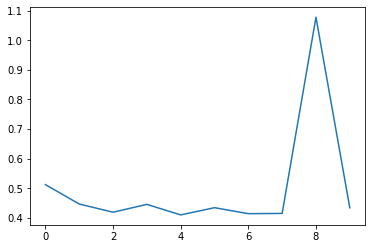

In [18]:
plt.plot(loss_array)
plt.show()